<a href="https://colab.research.google.com/github/eunzzae/Study_RS/blob/main/%5B%ED%98%91%EC%97%85%ED%95%84%ED%84%B0%EB%A7%81%5D_%EB%AA%A8%EB%8D%B8%EA%B8%B0%EB%B0%98_%ED%98%91%EC%97%85%ED%95%84%ED%84%B0%EB%A7%81_Matrix_Factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Factorization

* MovieLens 데이터셋 활용하기  
* SVD를 직접 구현하고, 적절한 k값 찾기  
* matrix factorization을 간단히 할 수 있는 파이썬 라이브러리 소개

In [1]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Dataset 불러오기

In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/패스트캠퍼스/[딥러닝] 추천시스템/data'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding = 'utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [4]:
train_df, test_df = train_test_split(ratings_df, test_size = 0.2, random_state = 1234)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


# Sparse Matrix 만들기

In [5]:
sparse_matrix = train_df.groupby('movieId').apply(lambda x: pd.Series(x['rating'].values, index=x['userId'])).unstack()
sparse_matrix.index.name = 'movieId'

sparse_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,NaN,2.5,NaN,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,NaN,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# fill sparse matrix with average of movie ratings
sparse_matrix_withmovie = sparse_matrix.apply(lambda x : x.fillna(x.mean()), axis=1)

# fill sparse matrix with average of user ratings
sparse_matrix_withuser = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [7]:
sparse_matrix_withmovie.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,3.893491,3.893491,3.893491,3.893491,4.000000,3.893491,4.500000,3.893491,3.893491,3.893491,...,4.000000,3.893491,4.000000,3.000000,4.000000,2.500000,3.893491,2.500000,3.893491,5.000000
2,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,4.000000,3.396341,3.396341,...,3.396341,4.000000,3.396341,3.396341,3.500000,3.396341,3.396341,2.000000,3.396341,3.396341
3,4.000000,3.454545,3.454545,3.454545,3.454545,5.000000,3.454545,3.454545,3.454545,3.454545,...,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545
4,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,...,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000
5,3.039474,3.039474,3.039474,3.039474,3.039474,5.000000,3.039474,3.039474,3.039474,3.039474,...,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474


In [8]:
sparse_matrix_withuser.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.320652,3.94,2.516667,3.631868,4.000000,3.504132,4.500000,3.486486,3.1,3.292035,...,4.000000,3.473684,4.000000,3.000000,4.000000,2.500000,3.772414,2.500000,3.275862,5.000000
2,4.320652,3.94,2.516667,3.631868,3.636364,3.504132,3.247967,4.000000,3.1,3.292035,...,4.396104,4.000000,3.494024,3.486842,3.500000,3.649718,3.772414,2.000000,3.275862,3.678709
3,4.000000,3.94,2.516667,3.631868,3.636364,5.000000,3.247967,3.486486,3.1,3.292035,...,4.396104,3.473684,3.494024,3.486842,3.255618,3.649718,3.772414,3.145865,3.275862,3.678709
4,4.320652,3.94,2.516667,3.631868,3.636364,3.504132,3.247967,3.486486,3.1,3.292035,...,4.396104,3.473684,3.494024,3.486842,3.255618,3.649718,3.772414,3.145865,3.275862,3.678709
5,4.320652,3.94,2.516667,3.631868,3.636364,5.000000,3.247967,3.486486,3.1,3.292035,...,4.396104,3.473684,3.494024,3.486842,3.255618,3.649718,3.772414,3.145865,3.275862,3.678709


# Matrix Factorization with SVD

In [9]:
def get_svd(s_matrix, k=300):
  u, s, vh = np.linalg.svd(s_matrix.transpose())
  S = s[:k]*np.identity(k, np.float64)
  T = u[:,:k]
  Dt = vh[:k, :]

  item_factors = np.transpose(np.matmul(S, Dt))
  user_factors= np.transpose(T)

  return item_factors, user_factors

## 1. with average movie ratings

In [10]:
item_factors, user_factors = get_svd(sparse_matrix_withmovie)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix_withmovie.columns.values, index=sparse_matrix_withmovie.index.values)

movie_prediction_result_df = prediction_result_df.transpose()

In [11]:
print(item_factors.shape)
print(user_factors.shape)

(8938, 300)
(300, 610)


8938*610 =(8938X300)(300X300)(300X610)

In [12]:
movie_prediction_result_df.head()

,1,2,3,4,5,6,7,8,9,10,...,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
1,3.908820,3.390957,4.035030,2.252912,3.053903,3.981066,3.183727,2.744891,2.909088,3.505548,...,0.999983,4.499925,3.499942,2.999950,3.999934,3.999934,3.499942,3.999934,3.499942,3.999934
2,3.911434,3.445683,3.461056,2.240729,2.998555,3.959505,3.151831,2.751379,2.910568,3.406105,...,0.999942,4.499739,3.499797,2.999826,3.999768,3.999768,3.499797,3.999768,3.499797,3.999768
3,3.896327,3.383747,3.439498,2.240612,3.049043,3.935766,3.174809,2.738581,2.910505,3.515399,...,1.000001,4.500004,3.500003,3.000003,4.000004,4.000004,3.500003,4.000004,3.500003,4.000004
4,3.881024,3.421886,3.427186,2.239842,3.057280,3.946683,3.197075,2.748549,2.921073,3.513596,...,0.999981,4.499913,3.499933,2.999942,3.999923,3.999923,3.499933,3.999923,3.499933,3.999923
5,4.018416,3.400912,3.493598,2.184629,3.156865,3.946429,3.246271,2.874286,2.903455,3.256205,...,1.000034,4.500155,3.500120,3.000103,4.000138,4.000138,3.500120,4.000138,3.500120,4.000138


## 2. with average user ratings

In [13]:
item_factors, user_factors = get_svd(sparse_matrix_withuser)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns = sparse_matrix_withuser.columns.values, index=sparse_matrix_withuser.index.values)

user_prediction_result_df=prediction_result_df.transpose()

In [14]:
user_prediction_result_df.head()

,1,2,3,4,5,6,7,8,9,10,...,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
1,4.362666,4.366280,3.966290,4.335373,4.363704,3.983660,4.303573,4.339269,4.305649,4.254211,...,4.318208,4.320182,4.320834,4.321160,4.320508,4.320508,4.320834,4.320508,4.320834,4.321664
2,4.018066,3.941879,3.903070,3.960808,3.907779,3.993262,3.913604,3.941605,3.919774,3.880579,...,3.924886,3.945287,3.937965,3.934304,3.941626,3.941626,3.937965,3.941626,3.937965,3.940416
3,2.503743,2.498854,2.491555,2.529266,2.509395,2.519116,2.486491,2.511599,2.508844,2.517707,...,2.526417,2.516350,2.516789,2.517009,2.516569,2.516569,2.516789,2.516569,2.516789,2.516032
4,3.624253,3.635961,3.619964,3.641844,3.632798,3.643807,3.636671,3.642801,3.615370,3.632327,...,3.631674,3.632685,3.631554,3.630989,3.632119,3.632119,3.631554,3.632119,3.631554,3.632004
5,4.051183,3.581114,3.721059,3.627674,3.519383,3.536805,3.768194,3.682646,3.571370,3.639438,...,3.586132,3.638168,3.635671,3.634422,3.636919,3.636919,3.635671,3.636919,3.635671,3.637667


In [15]:
item_factors.shape

(8938, 300)

# Compare user and movie scenario

In [16]:
def evaluate(test_df, prediction_result_df):
  groups_with_movie_ids = test_df.groupby(by='movieId')
  groups_with_user_ids = test_df.groupby(by='userId')
  intersection_movie_ids = sorted(list(set(list(prediction_result_df.columns)).intersection(set(list(groups_with_movie_ids.indices.keys())))))
  intersection_user_ids = sorted(list(set(list(prediction_result_df.index)).intersection(set(groups_with_user_ids.indices.keys()))))

  print(len(intersection_movie_ids))
  print(len(intersection_user_ids))

  compressed_prediction_df = prediction_result_df.loc[intersection_user_ids][intersection_movie_ids]

  # test_df에 대해서 RMSE 계산
  grouped = test_df.groupby(by='userId')
  rmse_df = pd.DataFrame(columns=['rmse'])
  for userId, group in tqdm(grouped):
      if userId in intersection_user_ids:
          pred_ratings = compressed_prediction_df.loc[userId][compressed_prediction_df.loc[userId].index.intersection(list(group['movieId'].values))]
          pred_ratings = pred_ratings.to_frame(name='rating').reset_index().rename(columns={'index':'movieId','rating':'pred_rating'})
          actual_ratings = group[['rating', 'movieId']].rename(columns={'rating':'actual_rating'})

          final_df = pd.merge(actual_ratings, pred_ratings, how='inner', on=['movieId'])
          final_df = final_df.round(4) # 반올림

          if not final_df.empty:
            rmse = sqrt(mean_squared_error(final_df['actual_rating'], final_df['pred_rating']))
            rmse_df.loc[userId] = rmse

  return final_df, rmse_df

In [17]:
result_df, _ = evaluate(test_df, user_prediction_result_df)
print(result_df)
print("For user matrix")
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

     actual_rating  movieId  pred_rating
0              5.0     3527       3.6789
1              3.5    84772       3.6783
2              3.5   103141       3.6758
3              4.0    81132       3.6785
4              4.5   130634       3.6785
..             ...      ...          ...
218            4.0   106100       3.6805
219            4.0   111759       3.6747
220            1.0     4852       3.6787
221            3.0     2628       3.6883
222            5.0     1953       3.6721

[223 rows x 3 columns]
For user matrix
RMSE: 0.8551691150767583


In [18]:
result_df, _ = evaluate(test_df, movie_prediction_result_df)
print(result_df)
print("For movie matrix")
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

     actual_rating  movieId  pred_rating
0              5.0     3527       3.6030
1              3.5    84772       3.0433
2              3.5   103141       4.0453
3              4.0    81132       3.5000
4              4.5   130634       3.2496
..             ...      ...          ...
218            4.0   106100       3.8314
219            4.0   111759       3.9239
220            1.0     4852       1.0000
221            3.0     2628       3.1901
222            5.0     1953       3.8234

[223 rows x 3 columns]
For movie matrix
RMSE: 0.8209361471321392


# Experiments on different k

In [19]:
def find_best_k(sparse_matrix, maximum_k=100):
  print("\nFind best optimized k for Matrix Factorization")
  k_candidates = np.arange(50, maximum_k, 10)
  final_df = pd.DataFrame(columns=['rmse'], index=k_candidates)
  for k in tqdm(k_candidates):
    item_factors, user_factors = get_svd(sparse_matrix, k)
    each_results_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                   columns=sparse_matrix.columns.values, index = sparse_matrix.index.values)
    each_results_df = each_results_df.transpose()

    result_df, _ = evaluate(test_df, each_results_df)
    each_rmse = sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))

    final_df.loc[k]['rmse']=each_rmse
  return final_df

grid search, cordinate search

In [20]:
res = find_best_k(sparse_matrix_withmovie, 200)


Find best optimized k for Matrix Factorization


<ipython-input-19-b0903233d57f>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(k_candidates):


  0%|          | 0/15 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

In [21]:
res

,rmse
50,0.823432
60,0.826151
70,0.825998
80,0.821733
90,0.823385
100,0.824104
110,0.823003
120,0.82306
130,0.822952
140,0.821839


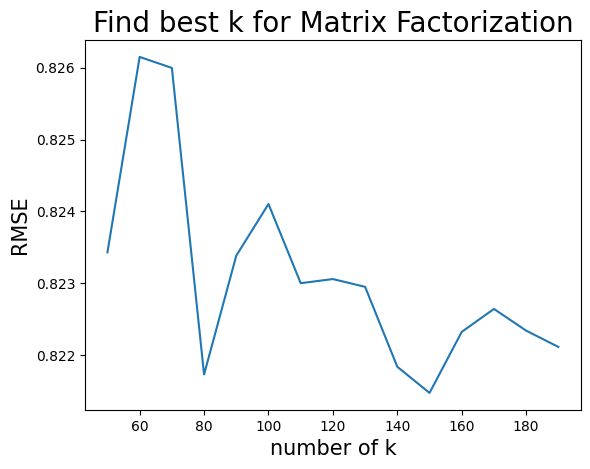

In [22]:
plt.plot(res.index, res.rmse)
plt.title("Find best k for Matrix Factorization", fontsize=20)
plt.xlabel("number of k", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.show()

# Matrix Factorization with Simple Python module

* https://pypi.org/project/matrix-factorization/

In [23]:
!pip install matrix-factorization

In [29]:
from matrix_factorization import BaselineModel, KernelMF, train_update_test_split

In [30]:
path = '/content/drive/MyDrive/Colab Notebooks/패스트캠퍼스/[딥러닝] 추천시스템/data'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding = 'utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [31]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


In [32]:
train_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [33]:
new_train_df = train_df
new_train_df=new_train_df.rename(columns= {'userId':'user_id', 'movieId':'item_id'})
new_train_df.head()

,user_id,item_id,rating,timestamp
95713,600,5943,3.0,1237714356
61560,407,2571,5.0,1424349171
77204,482,8958,4.0,1105397126
93367,599,2322,2.5,1498515283
90892,590,2959,3.5,1258416553


dataset => train valid test => train valid : 실제학습할때, test: 학습된 모델의 성능을 평가할 때 사용

In [34]:
(
    X_train_initial,
    y_train_initial,
    X_train_update,
    y_train_update,
    X_test_update,
    y_test_update,
) = train_update_test_split(new_train_df, frac_new_users=0.2)

In [35]:

# Initial training
matrix_fact = KernelMF(n_epochs=20, n_factors=100, verbose=1, lr=0.001, reg=0.005)
matrix_fact.fit(X_train_initial, y_train_initial)


Epoch  1 / 20  -  train_rmse: 0.9929790502255466
Epoch  2 / 20  -  train_rmse: 0.968927593076989
Epoch  3 / 20  -  train_rmse: 0.9528192678631473
Epoch  4 / 20  -  train_rmse: 0.9405600557612679
Epoch  5 / 20  -  train_rmse: 0.9306260753653778
Epoch  6 / 20  -  train_rmse: 0.922242923359965
Epoch  7 / 20  -  train_rmse: 0.9149369858816048
Epoch  8 / 20  -  train_rmse: 0.9084201790754985
Epoch  9 / 20  -  train_rmse: 0.9025149338093529
Epoch  10 / 20  -  train_rmse: 0.897083804233901
Epoch  11 / 20  -  train_rmse: 0.8920273626820052
Epoch  12 / 20  -  train_rmse: 0.8872925720990653
Epoch  13 / 20  -  train_rmse: 0.8828196782593944
Epoch  14 / 20  -  train_rmse: 0.8785737326254844
Epoch  15 / 20  -  train_rmse: 0.8744894672565082
Epoch  16 / 20  -  train_rmse: 0.8705784966412777
Epoch  17 / 20  -  train_rmse: 0.8668079093957353
Epoch  18 / 20  -  train_rmse: 0.8631576239798104
Epoch  19 / 20  -  train_rmse: 0.8596046674393953
Epoch  20 / 20  -  train_rmse: 0.856152400043942


KernelMF(gamma=0.01, lr=0.001, n_epochs=20, reg=0.005)

In [36]:
# Update model with new users
matrix_fact.update_users(
    X_train_update, y_train_update, lr=0.001, n_epochs=20, verbose=1
)

Epoch  1 / 20  -  train_rmse: 0.9580078952001928
Epoch  2 / 20  -  train_rmse: 0.9384761940710125
Epoch  3 / 20  -  train_rmse: 0.9242496185800476
Epoch  4 / 20  -  train_rmse: 0.9134305531938265
Epoch  5 / 20  -  train_rmse: 0.90490965651551
Epoch  6 / 20  -  train_rmse: 0.8979453264038287
Epoch  7 / 20  -  train_rmse: 0.8921009530783712
Epoch  8 / 20  -  train_rmse: 0.8871061338991513
Epoch  9 / 20  -  train_rmse: 0.8827600765633755
Epoch  10 / 20  -  train_rmse: 0.8789365007856181
Epoch  11 / 20  -  train_rmse: 0.8755208611458729
Epoch  12 / 20  -  train_rmse: 0.87245697563822
Epoch  13 / 20  -  train_rmse: 0.8696690004835385
Epoch  14 / 20  -  train_rmse: 0.8671163683249344
Epoch  15 / 20  -  train_rmse: 0.8647731992393328
Epoch  16 / 20  -  train_rmse: 0.8625977385934664
Epoch  17 / 20  -  train_rmse: 0.8605672034117672
Epoch  18 / 20  -  train_rmse: 0.8586617256301807
Epoch  19 / 20  -  train_rmse: 0.8568686182129062
Epoch  20 / 20  -  train_rmse: 0.8551739428949652


In [37]:
pred = matrix_fact.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared=False)
print(f"\nTest RMSE: {rmse:.4f}")


Test RMSE: 0.8781


In [38]:
# Get recommendations
user = 200
items_known = X_train_initial.query("user_id == @user")["item_id"]
matrix_fact.recommend(user=user, items_known=items_known)

,user_id,item_id,rating_pred
436,200,527,4.489305
118,200,1221,4.464737
357,200,1196,4.399305
554,200,858,4.362570
354,200,260,4.361274
827,200,50,4.349656
2179,200,8874,4.347169
710,200,48516,4.336886
1942,200,1276,4.324226
347,200,912,4.324189


# SGD

In [39]:
baseline_model = BaselineModel(method='sgd', n_epochs = 20, reg = 0.005, lr = 0.01, verbose=1)
baseline_model.fit(X_train_initial, y_train_initial)

pred = baseline_model.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 0.9093503997880462
Epoch  2 / 20  -  train_rmse: 0.8845978140172089
Epoch  3 / 20  -  train_rmse: 0.8701727855586829
Epoch  4 / 20  -  train_rmse: 0.8601879731301306
Epoch  5 / 20  -  train_rmse: 0.8525419103823819
Epoch  6 / 20  -  train_rmse: 0.8467452741829512
Epoch  7 / 20  -  train_rmse: 0.8415972192163741
Epoch  8 / 20  -  train_rmse: 0.8368918292949927
Epoch  9 / 20  -  train_rmse: 0.8335105004595403
Epoch  10 / 20  -  train_rmse: 0.830010374212455
Epoch  11 / 20  -  train_rmse: 0.8271311947419021
Epoch  12 / 20  -  train_rmse: 0.824879216141685
Epoch  13 / 20  -  train_rmse: 0.8223791608939959
Epoch  14 / 20  -  train_rmse: 0.8202903259584158
Epoch  15 / 20  -  train_rmse: 0.8183635360303352
Epoch  16 / 20  -  train_rmse: 0.8162992476477711
Epoch  17 / 20  -  train_rmse: 0.8146327261947907
Epoch  18 / 20  -  train_rmse: 0.8132278623015596
Epoch  19 / 20  -  train_rmse: 0.8121356918029824
Epoch  20 / 20  -  train_rmse: 0.8104297996458817

Test RMSE:

In [40]:
%%time
baseline_model.update_users(X_train_update, y_train_update, n_epochs=20, lr=0.001, verbose=1)
pred = baseline_model.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 0.9383735012314518
Epoch  2 / 20  -  train_rmse: 0.9193658115585018
Epoch  3 / 20  -  train_rmse: 0.9056303697130639
Epoch  4 / 20  -  train_rmse: 0.8954035400942497
Epoch  5 / 20  -  train_rmse: 0.8875048248518114
Epoch  6 / 20  -  train_rmse: 0.8811777434827787
Epoch  7 / 20  -  train_rmse: 0.8759964761903019
Epoch  8 / 20  -  train_rmse: 0.8716841883659522
Epoch  9 / 20  -  train_rmse: 0.8680616353997496
Epoch  10 / 20  -  train_rmse: 0.8649848133089486
Epoch  11 / 20  -  train_rmse: 0.8623365182829301
Epoch  12 / 20  -  train_rmse: 0.860033494033757
Epoch  13 / 20  -  train_rmse: 0.8580257819554247
Epoch  14 / 20  -  train_rmse: 0.8562692500844551
Epoch  15 / 20  -  train_rmse: 0.8547185062498996
Epoch  16 / 20  -  train_rmse: 0.8533475608538493
Epoch  17 / 20  -  train_rmse: 0.8521258190491885
Epoch  18 / 20  -  train_rmse: 0.8510375284571234
Epoch  19 / 20  -  train_rmse: 0.8500598026394469
Epoch  20 / 20  -  train_rmse: 0.8491810815706259

Test RMSE

# ALS

In [41]:
baseline_model = BaselineModel(method='als', n_epochs = 20, reg = 0.5, verbose=1)
baseline_model.fit(X_train_initial, y_train_initial)

pred = baseline_model.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 0.7965470040901108
Epoch  2 / 20  -  train_rmse: 0.7794826571361435
Epoch  3 / 20  -  train_rmse: 0.7779670401035438
Epoch  4 / 20  -  train_rmse: 0.7777281291752914
Epoch  5 / 20  -  train_rmse: 0.777665340820843
Epoch  6 / 20  -  train_rmse: 0.7776390883946916
Epoch  7 / 20  -  train_rmse: 0.7776227313757177
Epoch  8 / 20  -  train_rmse: 0.7776098972026966
Epoch  9 / 20  -  train_rmse: 0.7775988451945259
Epoch  10 / 20  -  train_rmse: 0.7775890169270929
Epoch  11 / 20  -  train_rmse: 0.7775801795923858
Epoch  12 / 20  -  train_rmse: 0.7775721998597724
Epoch  13 / 20  -  train_rmse: 0.7775649807250069
Epoch  14 / 20  -  train_rmse: 0.7775584424264358
Epoch  15 / 20  -  train_rmse: 0.7775525159108221
Epoch  16 / 20  -  train_rmse: 0.7775471401356209
Epoch  17 / 20  -  train_rmse: 0.7775422606646434
Epoch  18 / 20  -  train_rmse: 0.7775378287612003
Epoch  19 / 20  -  train_rmse: 0.7775338007068803
Epoch  20 / 20  -  train_rmse: 0.7775301372434085

Test RMSE

In [ ]:
%%time